Decent model

Test loss: 0.058192502707242966 / Test accuracy: 0.9704641103744507 (on testing set (newdata))

Still somewhat unstable, but have high confidence.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models,layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D
from keras.optimizers import Adam, RMSprop
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tf.keras.backend.clear_session()

In [4]:
# import shutil
# shutil.rmtree("Kentang-data")

%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Split train test 
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/DiseasedPlants/Perkebunan/Kentang", output="Kentang-data", seed=2001, ratio=(.8, .1,.1), group_prefix=None) 


Copying files: 2341 files [00:30, 78.00 files/s] 


In [6]:
training_dir = os.path.join('Kentang-data', 'train')
testing_dir = os.path.join('Kentang-data', 'test')
validating_dir = os.path.join('Kentang-data', 'val')

In [7]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	training_dir,
    shuffle=True,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	validating_dir,
	target_size=(224,224),
    shuffle=True,
	class_mode='categorical',
  batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 1871 images belonging to 3 classes.
Found 233 images belonging to 3 classes.
Found 237 images belonging to 3 classes.


In [8]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)

{'Potato__early_blight': 0, 'Potato__healthy': 1, 'Potato__late_blight': 2}
['Potato__early_blight', 'Potato__healthy', 'Potato__late_blight']


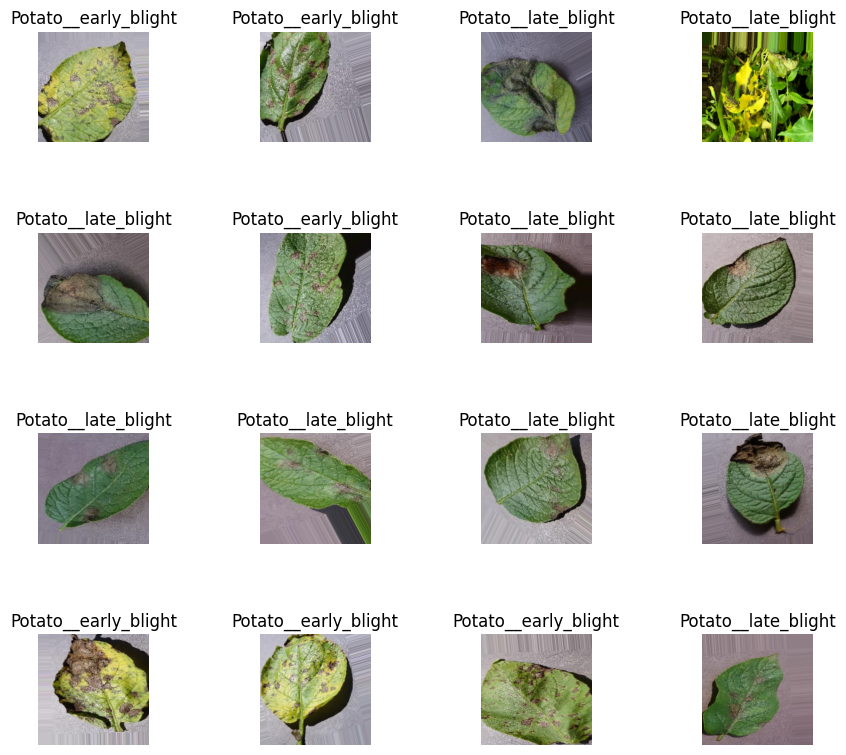

In [9]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()


In [10]:
# Define Callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')>=0.98):   
            keys = list(logs.keys())
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
            self.model.stop_training = True
            
# define object from CustomCallback Class
callbacks = CustomCallback()

In [11]:
def generator_to_dataset(generator):
    output_types = (tf.float32, tf.float32)
    output_shapes = (tf.TensorShape([None, 224, 224, 3]), tf.TensorShape([None, generator.num_classes]))

    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=output_types,
        output_shapes=output_shapes
    )

    return dataset

train_dataset = generator_to_dataset(train_generator)
validation_dataset = generator_to_dataset(validation_generator)
testing_dataset = generator_to_dataset(testing_generator)

buffer_size = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
validation_dataset = validation_dataset.prefetch(buffer_size=buffer_size)
testing_dataset = testing_dataset.prefetch(buffer_size=buffer_size)

In [12]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(248, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, 
                    epochs=100,
                    validation_data = validation_generator, 
                    verbose = 1, 
                    callbacks=[CustomCallback()], 
                    validation_steps=3)

Epoch 1/100
59/59 [==============================] - 43s 450ms/step - loss: 0.9171 - accuracy: 0.4858 - val_loss: 0.9104 - val_accuracy: 0.4479
Epoch 2/100
59/59 [==============================] - 26s 441ms/step - loss: 0.8650 - accuracy: 0.5222 - val_loss: 0.8777 - val_accuracy: 0.4792
Epoch 3/100
59/59 [==============================] - 26s 448ms/step - loss: 0.7588 - accuracy: 0.6291 - val_loss: 0.5794 - val_accuracy: 0.7500
Epoch 4/100
59/59 [==============================] - 27s 451ms/step - loss: 0.7864 - accuracy: 0.6398 - val_loss: 0.8334 - val_accuracy: 0.5729
Epoch 5/100
59/59 [==============================] - 26s 446ms/step - loss: 0.6515 - accuracy: 0.7263 - val_loss: 0.6155 - val_accuracy: 0.7188
Epoch 6/100
59/59 [==============================] - 27s 451ms/step - loss: 0.5625 - accuracy: 0.7745 - val_loss: 0.5540 - val_accuracy: 0.7604
Epoch 7/100
59/59 [==============================] - 26s 448ms/step - loss: 0.4964 - accuracy: 0.8065 - val_loss: 0.5672 - val_accuracy:

In [22]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

8/8 [==============================] - 1s 165ms/step - loss: 0.0582 - accuracy: 0.9705
Test loss: 0.058192502707242966 / Test accuracy: 0.9704641103744507


In [27]:
predictions = model.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = testing_generator.classes
class_labels = list(testing_generator.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes, predicted_classes, target_names=class_labels))
print(confusion_matrix(true_classes, predicted_classes))



8/8 [==============================] - 1s 98ms/step
                      precision    recall  f1-score   support

Potato__early_blight       0.48      0.49      0.48       111
     Potato__healthy       0.06      0.06      0.06        16
 Potato__late_blight       0.47      0.46      0.47       110

            accuracy                           0.45       237
           macro avg       0.34      0.34      0.34       237
        weighted avg       0.45      0.45      0.45       237

[[54  8 49]
 [ 6  1  9]
 [52  7 51]]


Potato__early_blight: 54 true positives, 6 false positives, and 51 false negatives.

Potato__healthy: 0 true positives, 8 false positives, and 8 false negatives.

Potato__late_blight: 50 true positives, 10 false positives, and 50 false negatives.


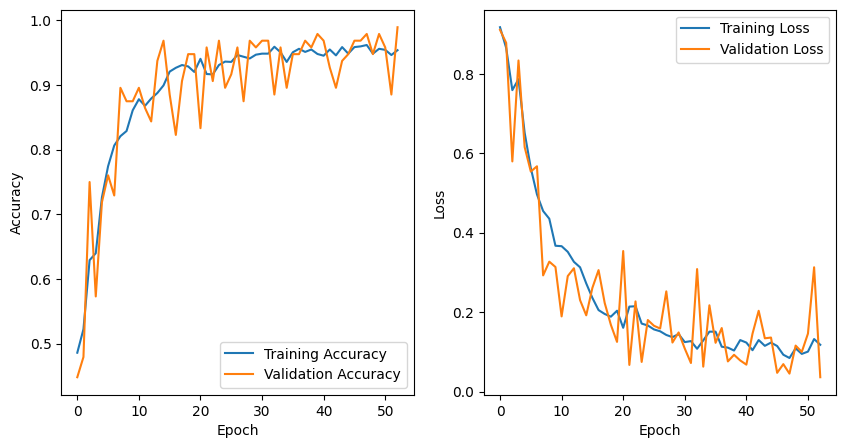

In [17]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
def plot_images(images, true_labels, predicted_labels, predicted_probs):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]} ({predicted_probs[i]:.2%})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images, labels = next(iter(testing_generator))
predicted_probs = model.predict(images)
predicted_labels = [class_labels[i] for i in np.argmax(predicted_probs, axis=1)]
true_labels = [class_labels[i] for i in np.argmax(labels, axis=1)]
predicted_probs = np.max(predicted_probs, axis=1)

plot_images(images, true_labels, predicted_labels, predicted_probs)


1/1 [==============================] - 0s 35ms/step


Found 1871 images belonging to 3 classes.
1/1 [==============================] - 0s 66ms/step


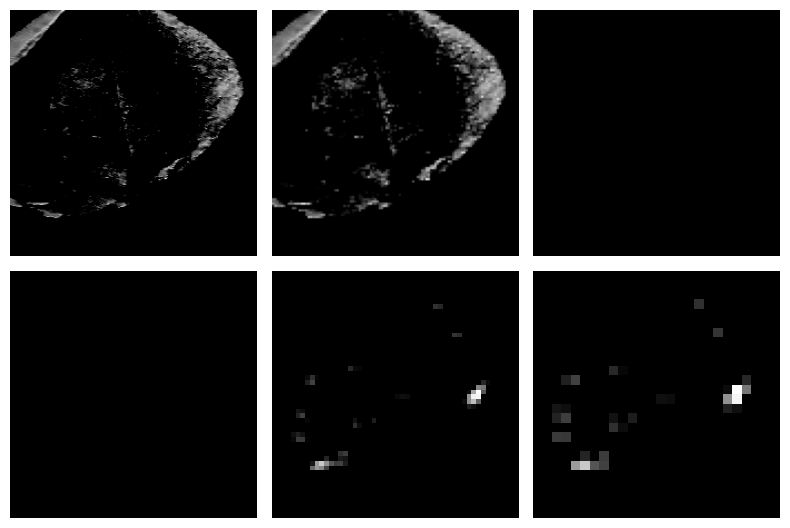

1/1 [==============================] - 0s 24ms/step


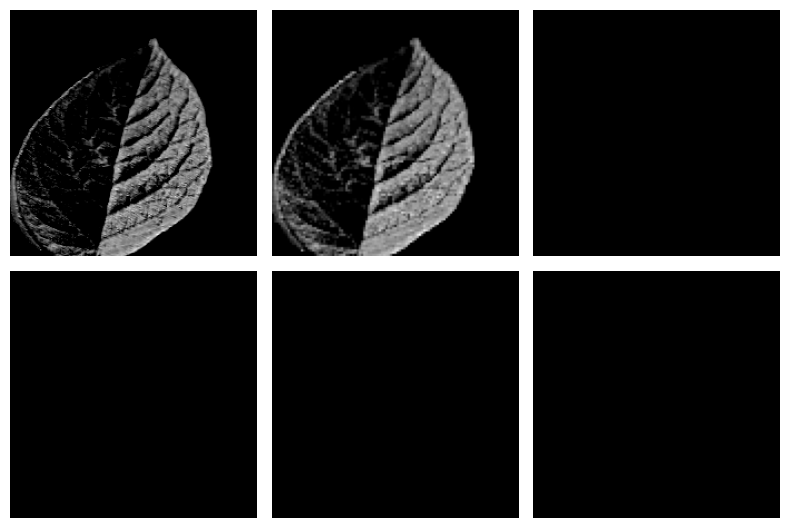

1/1 [==============================] - 0s 22ms/step


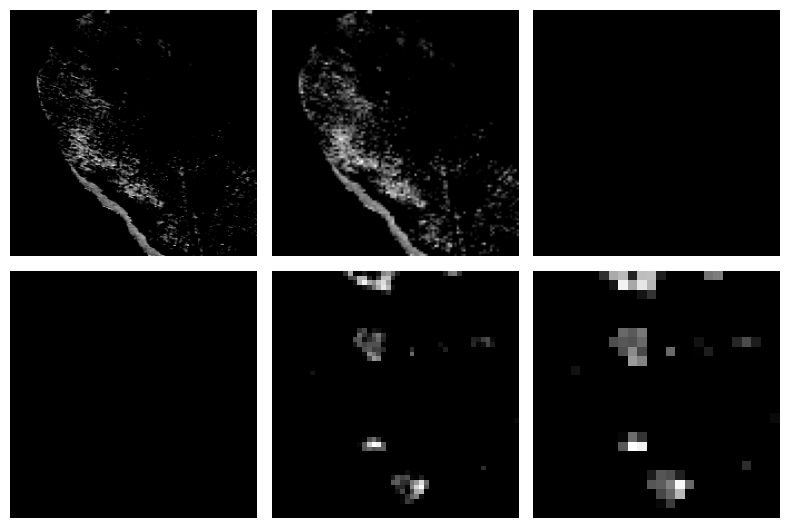

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


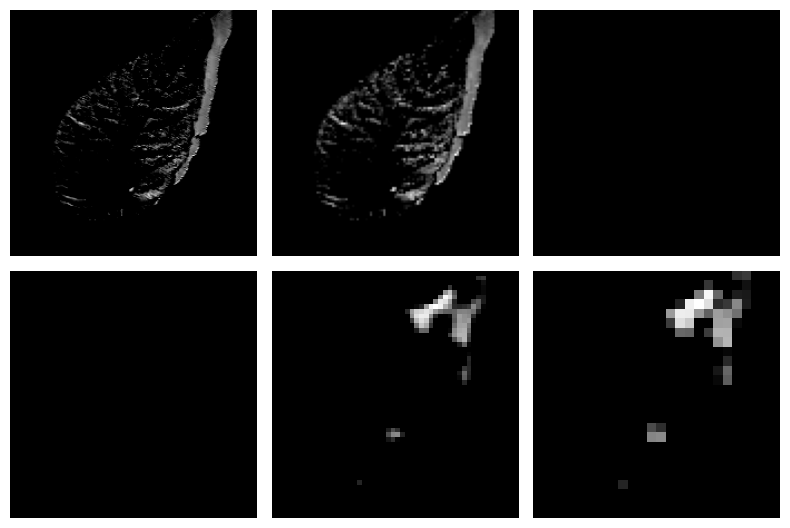

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


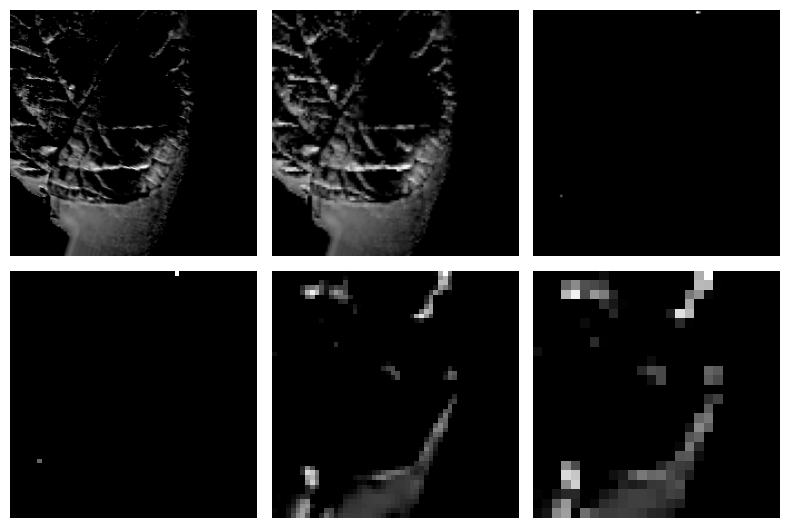

1/1 [==============================] - 0s 23ms/step


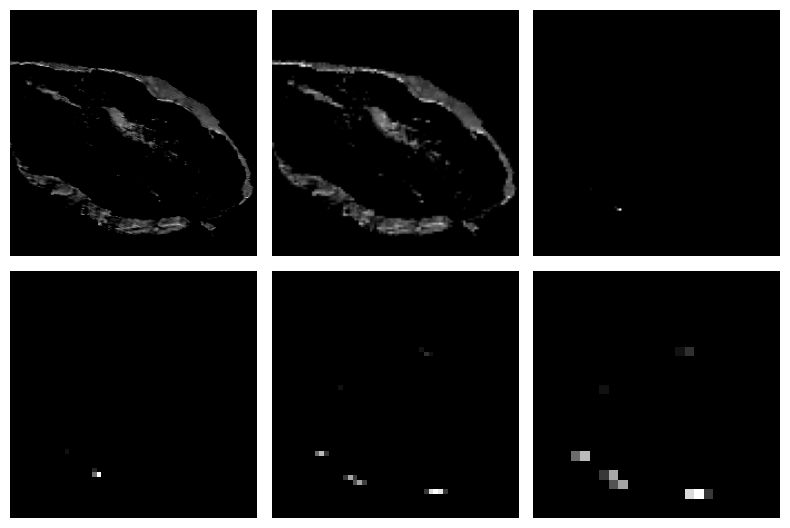

1/1 [==============================] - 0s 22ms/step


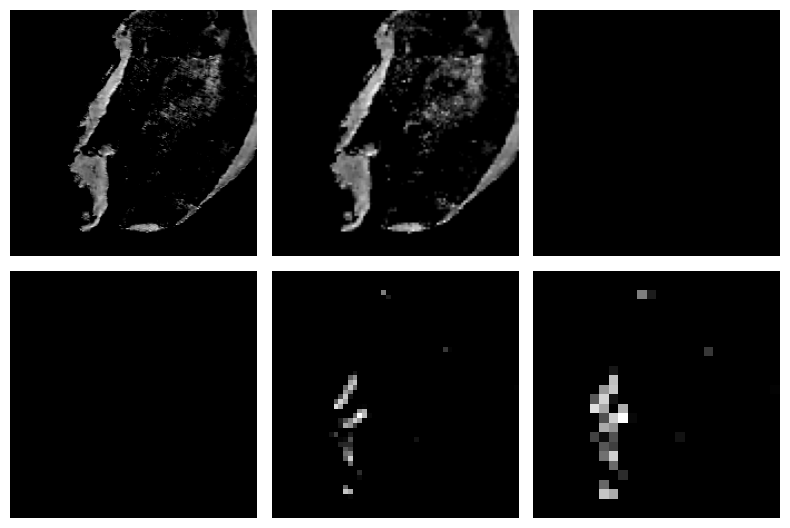

1/1 [==============================] - 0s 25ms/step


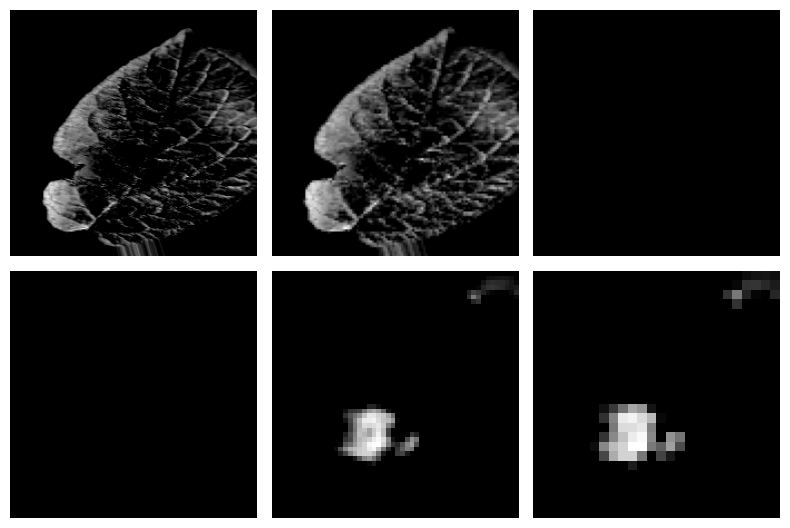

In [20]:
# Use the training_datagen defined earlier to apply data augmentation
# and create a generator with a batch size of 10
future_maps_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=10
)

# Retrieve 10 images from the generator
images, labels = next(future_maps_generator)

# Get the predicted class probabilities for each image
pred_probs = model.predict(images)

# Get the predicted and actual class names for each image
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
pred_classes = [class_names[np.argmax(pred_probs[i])] for i in range(len(images))]
actual_classes = [class_names[np.argmax(labels[i])] for i in range(len(images))]

layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Visualize the feature maps for each image along with the predicted and actual class names
for idx, image in enumerate(images):
    # Expand dimensions for single image prediction
    image = np.expand_dims(image, axis=0)

    # Get the feature maps for the current image
    activations = activation_model.predict(image)

    # Plot the feature maps and class names
    plt.figure(figsize=(8, 8))
    for i in range(len(activations)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(activations[i][0, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [26]:
model.save('kentangv5.h5')